<a href="https://colab.research.google.com/github/Priyanka-code-sys/Thesis_Priyanka/blob/main/cnn_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#set the memory growth in the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
#define strategy to use multiple gpus
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
#load the dataset
df = pd.read_pickle('/content/drive/MyDrive/priyanka_code_data/final_code/dataset.pkl')

FileNotFoundError: ignored

In [ ]:
df.head(10)

,review,star_rating
1383873,don t trust the publicity if john fowler is ca...,0.4
1141448,mesmerising how can a record so submerged in m...,0.8
232149,oui que vous dire sur une marchandise que j a...,0.6
101990,mais où est donc passée la finesse de gaiman ...,0.2
91339,moins inspiré je suis personnellement un peu d...,0.6
892867,disappointed i don t right reviews very often ...,0.4
221800,trop petit j ai retourné l article car joli ma...,0.4
47253,je l adore mais oui j adore stanley clarke m...,0.6
425195,transformer dark of the moon megatron blu ray ...,0.6
56946,un groupe toujours aussi prenant dommage que...,1.0


In [ ]:
#split the sentences
df['clean_text'] = df['review'].map(lambda x:str(x).split())

In [ ]:
df.head(5)

,review,star_rating,clean_text
1383873,don t trust the publicity if john fowler is ca...,0.4,"[don, t, trust, the, publicity, if, john, fowl..."
1141448,mesmerising how can a record so submerged in m...,0.8,"[mesmerising, how, can, a, record, so, submerg..."
232149,oui que vous dire sur une marchandise que j a...,0.6,"[oui, que, vous, dire, sur, une, marchandise, ..."
101990,mais où est donc passée la finesse de gaiman ...,0.2,"[mais, où, est, donc, passée, la, finesse, de,..."
91339,moins inspiré je suis personnellement un peu d...,0.6,"[moins, inspiré, je, suis, personnellement, un..."


In [ ]:
#load the datasets
f = open("/content/drive/MyDrive/priyanka_code_data/final_code/features.pkl",'rb')
X = pickle.load(f)
f = open("/content/drive/MyDrive/priyanka_code_data/final_code/labels.pkl",'rb')
Y = pickle.load(f)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=512, split=' ')
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
X = pad_sequences(X)

In [ ]:
#check the features and vectors
print(X[:2])
print(Y[:2])

[[  0   0   0 ...  35  20  76]
 [  0   0   0 ...  10   5 431]]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [ ]:
#train test split
X_train = X[:80000]
Y_train = Y[:80000]

X_test = X[80000:]
Y_test = Y[80000:]

In [ ]:
from keras.layers import Input, Concatenate, Dense, Embedding, LSTM,SpatialDropout1D,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential

In [ ]:
#define convolution based model
with strategy.scope():
    model = Sequential()
    model.add(Embedding(50000, 128, input_length= X.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5,activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3725, 128)         6400000   
                                                                 
 conv1d (Conv1D)             (None, 3723, 32)          12320     
                                                                 
 conv1d_1 (Conv1D)           (None, 3721, 64)          6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 3719, 64)          12352     
                                                                 
 flatten (Flatten)           (None, 238016)            0         
                                                                 
 dense (Dense)               (None, 64)                15233088  
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [ ]:
pred = model.predict(X_train[:3])
print(pred)

Instructions for updating:
use `experimental_local_results` instead.
[[0.19949023 0.20171452 0.19914332 0.19788241 0.20176956]
 [0.19914864 0.20307572 0.19798453 0.19690154 0.20288959]
 [0.19924158 0.20303297 0.19782303 0.19686182 0.20304063]]


In [ ]:
#fit the model on the dataset
history = model.fit(X_train,Y_train,epochs=3,batch_size=8,validation_split=0.2)

Epoch 1/3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

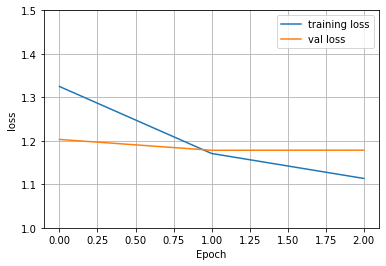

In [ ]:
#plot the history
import matplotlib.pyplot as plt
def plot_loss():
  plt.plot([1.3250,1.1709,1.1135], label='training loss')
  plt.plot([1.2032,1.1783,1.1785], label='val loss')
  plt.ylim([1.0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)
plot_loss()#plot the history


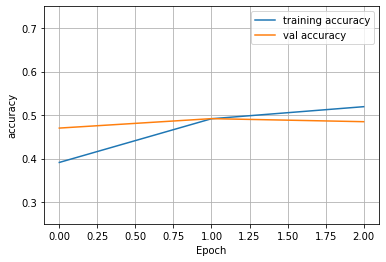

In [ ]:
def plot_accuracy():
  plt.plot([0.3911,0.4916,0.5193], label='training accuracy')
  plt.plot([0.4701,0.4918,0.4848], label='val accuracy')
  plt.ylim([0.25, 0.75])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)
plot_accuracy()#plot the history

In [ ]:
#save the model
model.save('./cnn_model')

INFO:tensorflow:Assets written to: ./cnn_model/assets


In [ ]:
#evaluate the model
model.evaluate(X_test,Y_test)

625/625 [==============================] - 16s 22ms/step - loss: 1.1599 - accuracy: 0.4916


[1.1599031686782837, 0.4916499853134155]

In [ ]:
Y_preds = model.predict(X_test)
print(Y_preds.shape)

(20000, 5)


In [ ]:
Y_preds_single = np.argmax(Y_preds,axis=1)
Y_real = np.argmax(Y_test,axis=1)

In [ ]:
#calculate the precision,recall,f1 score,confusion matrix for the model
from sklearn.metrics import f1_score,recall_score,precision_score,ConfusionMatrixDisplay

In [ ]:
#plot the f1 score the model across different classes
f1 = f1_score(Y_real,Y_preds_single,average=None)
recall = recall_score(Y_real,Y_preds_single,average=None)
precision = precision_score(Y_real,Y_preds_single,average=None)

In [ ]:
print("Weighted F1 Score : ",f1_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Recall Score : ",recall_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Precision Score : ",precision_score(Y_real,Y_preds_single,average="weighted"))

Weighted F1 Score :  0.4880161132164704
Weighted Recall Score :  0.49165
Weighted Precision Score :  0.48724113206658604


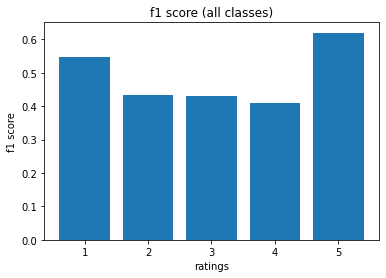

In [ ]:
#plot the f1 score
x = [1,2,3,4,5]
plt.bar(x,f1,label='f1 score')
plt.title('f1 score (all classes)')
plt.xlabel('ratings')
plt.ylabel('f1 score')
plt.show()

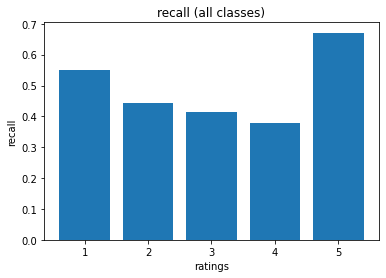

In [ ]:
#plot the recall
x = [1,2,3,4,5]
plt.bar(x,recall,label='recall')
plt.title('recall (all classes)')
plt.xlabel('ratings')
plt.ylabel('recall')
plt.show()

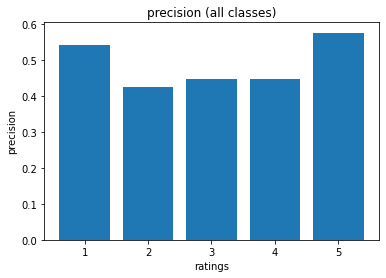

In [ ]:
#precision
x = [1,2,3,4,5]
plt.bar(x,precision,label='precision')
plt.title('precision (all classes)')
plt.xlabel('ratings')
plt.ylabel('precision')
plt.show()

In [ ]:
#output the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_real,Y_preds_single)
print(cm)

[[2211 1075  277  174  277]
 [ 952 1773  823  243  212]
 [ 389  897 1653  758  300]
 [ 233  273  783 1513 1186]
 [ 291  151  171  702 2683]]


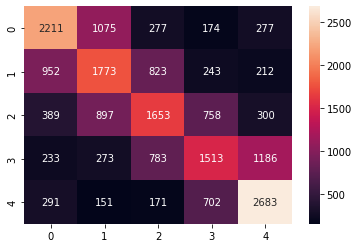

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='g')

In [ ]:
#function to test our own statements
import re

values = X_test[:3]
print(values)
preds = model.predict(values)
print("the number of stars in the process = ",np.argmax(preds,axis=1)+1)

[[  0   0   0 ...  46 167  90]
 [  0   0   0 ... 327 187  78]
 [  0   0   0 ...  45   6 296]]
the number of stars in the process =  [2 2 2]
